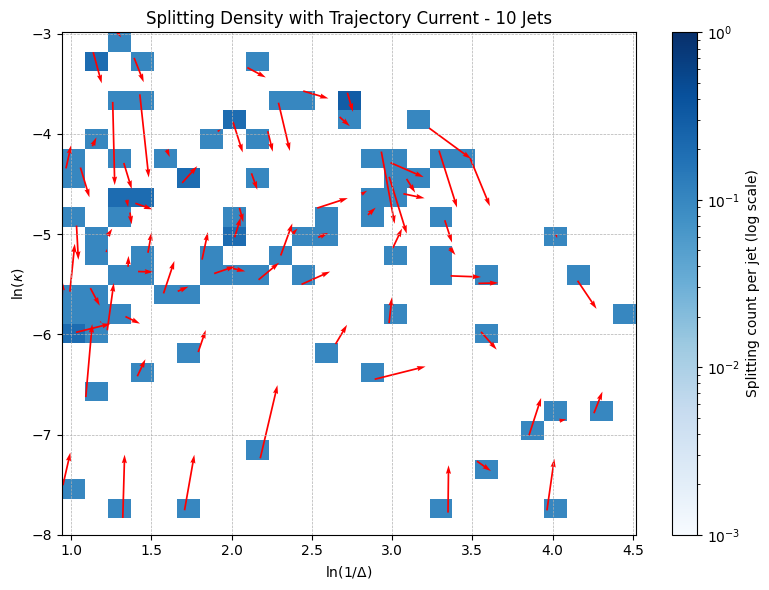

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('pythia_lund_jet.parquet')

s_kt_or_kappa = 'kt'
s_kt_or_kappa = 'kappa'

# Extract lund records from all jets
records = []
for _, row in df_jets.iterrows():
    lunds = row['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i][s_kt_or_kappa], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1][s_kt_or_kappa], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

y_limit_low = df['y'].min()
y_limit_low = -8
if s_kt_or_kappa == 'kt':
    # Apply cut for plotting only (ln(kT) > -4)
    y_limit_low = -4

df_plot = df[df['y'] > y_limit_low]
group_plot = group[group['y'] > y_limit_low]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(df_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver only for arrows starting at ln(kT) > -4)
plt.quiver(group_plot['x'], group_plot['y'], group_plot['dx'], group_plot['dy'], 
           angles='xy', scale_units='xy', scale=5, width=0.003, color='red', alpha=1.0)

plt.xlabel(r'$\ln(1/\Delta)$')
ylabel_latex = r'$\ln(k_T)$' if s_kt_or_kappa == 'kt' else r'$\ln(\kappa)$'
plt.ylabel(ylabel_latex)
plt.ylim(y_limit_low, None)
plt.title(f'Splitting Density with Trajectory Current - {len(df_jets)} Jets')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()